In [24]:
import numpy as np
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.optimizers import SGD
from keras.utils import np_utils

In [2]:
METHOD = 'cnn_autoencoder'

LABELLED_DATA_FILE = 'data/all_label.p'
UNLABELED_DATA_FILE = 'data/all_unlabel.p'
TEST_DATA_FILE = 'data/test.p'

OUTPUT_FOLDER = 'output/'
MODEL_FOLDER = 'model/' + METHOD + '/'

In [3]:
import os
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Train

### Loading Training Data

In [4]:
labelled_data = np.array(pickle.load(open(LABELLED_DATA_FILE, 'rb')))
unlabeled_data = np.array(pickle.load(open(UNLABELED_DATA_FILE, 'rb')))

In [5]:
nb_classes = 10
img_rows, img_cols, img_channels = 32, 32, 3

In [6]:
# generate x, y from data

# reshape labelled data to (5000, 3, 32, 32)
X_train_label = labelled_data.reshape((5000, img_channels, img_rows, img_cols)).astype('float32') / 255

# reshape unlabeled data to (45000, 3, 32, 32)
nb_unlabeled_data = unlabeled_data.shape[0]
X_train_unlabel = unlabeled_data.reshape((nb_unlabeled_data, img_channels, img_rows, img_cols)).astype('float32') / 255

X_train_all = np.concatenate((X_train_label, X_train_unlabel))

y_train_label_class = np.array([classIdx for classIdx in range(len(labelled_data)) for i in range(len(labelled_data[classIdx]))])
Y_train_label = np_utils.to_categorical(y_train_label_class, nb_classes)

In [7]:
# TODO: remove

from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# X_train_cifar = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_train]) / 255.0
X_test_cifar = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_test]) / 255.0
Y_test_cifar = np_utils.to_categorical(y_test.flatten(), 10)

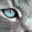

In [8]:
# visualize
from scipy.misc import toimage
toimage(X_train_unlabel[5])

### Training

#### autoencoder

In [104]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(3, 32, 32))

x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(input_img)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = MaxPooling2D((2, 2), border_mode='same', dim_ordering="th")(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = MaxPooling2D((2, 2), border_mode='same', dim_ordering="th")(x)
x = Convolution2D(16, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)

encoded = x

x = Convolution2D(16, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = UpSampling2D((2, 2), dim_ordering="th")(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = UpSampling2D((2, 2), dim_ordering="th")(x)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
# x = UpSampling2D((2, 2), dim_ordering="th")(x)
decoded = Convolution2D(3, 3, 3, activation='sigmoid', border_mode='same', dim_ordering="th")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [105]:
nb_epoch = 5
batch_size = 64

In [106]:
autoencoder.fit(X_train_all, X_train_all,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True)

Epoch 1/5
50000/50000 [==============================] - 42s - loss: 0.5827    
Epoch 2/5
50000/50000 [==============================] - 41s - loss: 0.5651    
Epoch 3/5
50000/50000 [==============================] - 41s - loss: 0.5616    
Epoch 4/5
50000/50000 [==============================] - 41s - loss: 0.5596    
Epoch 5/5
50000/50000 [==============================] - 40s - loss: 0.5584    


In [107]:
encoder = Model(input=input_img, output=encoded)

In [108]:
X_train_label_encoded = encoder.predict(X_train_label)
# TODO: remove cifar
X_test_cifar_encoded = encoder.predict(X_test_cifar)

In [109]:
X_train_label_decoded = autoencoder.predict(X_train_label)

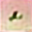

In [115]:
toimage(X_train_label_decoded[2])

#### classify

In [112]:
classifier = Sequential()

classifier.add(Flatten(input_shape=X_train_label_encoded.shape[1:]))

classifier.add(Dense(256))  # 32 * 
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(256))  # 32 * 
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(nb_classes))
classifier.add(Activation('softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [113]:
nb_epoch = 100
batch_size = 64

In [114]:
classifier.fit(X_train_label_encoded, Y_train_label,
    batch_size=batch_size,
    nb_epoch=nb_epoch,  # nb_epoch,
    validation_data=(X_test_cifar_encoded, Y_test_cifar),
    shuffle=True)

Train on 5000 samples, validate on 10000 samples
Epoch 1/100
5000/5000 [==============================] - 0s - loss: 2.2340 - acc: 0.1838 - val_loss: 2.2140 - val_acc: 0.1902
Epoch 2/100
5000/5000 [==============================] - 0s - loss: 2.0884 - acc: 0.2394 - val_loss: 2.2016 - val_acc: 0.2038
Epoch 3/100
5000/5000 [==============================] - 0s - loss: 2.0303 - acc: 0.2624 - val_loss: 2.1979 - val_acc: 0.1922
Epoch 4/100
5000/5000 [==============================] - 0s - loss: 1.9987 - acc: 0.2806 - val_loss: 2.2487 - val_acc: 0.1990
Epoch 5/100
5000/5000 [==============================] - 0s - loss: 1.9663 - acc: 0.2960 - val_loss: 2.2906 - val_acc: 0.1994
Epoch 6/100
5000/5000 [==============================] - 0s - loss: 1.9330 - acc: 0.3058 - val_loss: 2.2514 - val_acc: 0.2075
Epoch 7/100
5000/5000 [==============================] - 0s - loss: 1.9156 - acc: 0.3168 - val_loss: 2.2800 - val_acc: 0.1958
Epoch 8/100
5000/5000 [==============================] - 0s - loss: 1

In [ ]:
Y_train_label_class_predict = model.predict_classes(X_train_ori_label, batch_size=5000)
val_acc = np.sum(Y_train_label_class_predict == y_train_label_class) / float(len(y_train_label_class))
val_acc

In [ ]:
model_name = (METHOD
    + '_filters-64x3x3-64x3x3-512'
    + '_epo-100x5' # + str(nb_epoch)
    + '_val-acc-' + str(val_acc)[:6]
)
model.save(MODEL_FOLDER + model_name)

# Test

### Loading test data 

In [ ]:
test_data = pickle.load(open(TEST_DATA_FILE, 'rb'))  # dict
X_test = np.array(test_data['data']).reshape((10000, 3, 32, 32)).astype('float32')
X_test /= 255

### Predict

In [ ]:
result = model.predict_classes(X_test, batch_size=10000)
csv_content = list(zip(test_data['ID'], result.tolist()))
np.savetxt(OUTPUT_FOLDER + model_name + ".csv", csv_content, fmt="%i", header="ID,class", comments="", delimiter=",")

In [ ]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
X_train_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_train])
X_test_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_test])

In [ ]:
Y_test_class_predict = model.predict_classes(X_test_reshaped, batch_size=10000)
np.sum(Y_test_class_predict == y_test.flatten()) / len(y_test)

In [ ]:
Y_train_class_predict = model.predict_classes(X_train_reshaped, batch_size=10000)
np.sum(Y_train_class_predict == y_train.flatten()) / len(y_train)

In [ ]:
toimage(X_train_reshaped[2])

In [ ]:
Y_train_class_predict[:10]

In [ ]:
y_train[:10]

In [ ]:
toimage(X_train_reshaped[1])